In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False

In [5]:
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")

2024-02-06 15:32:35,984 | INFO     |: info
2024-02-06 15:32:35,985 | WARNING  |: warning
2024-02-06 15:32:35,986 | ERROR    |: error
2024-02-06 15:32:35,997 | CRITICAL |: critical


In [3]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2024-02-13 14:49:26,826 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:85:6a:10:3c
2024-02-13 14:49:35,529 | INFO     |: Connected to c0:83:85:6a:10:3c


/Users/ashley/workspace/ece4160/FastRobots_ble/ble_robot-1.1/ble_python/base_ble.py:91: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [4]:
ble.send_command(CMD.ECHO, "the fitness gram pacer test")

In [5]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

Robot says -> the fitness gram pacer test


In [6]:
stamped_data = []

def notification_handler(uuid, char_val_array):
    str_data = char_val_array.decode()[2:]
    data = str_data.split(',')
    stamped_data.append(data)

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [35]:
stamped_data.clear()
ble.send_command(CMD.GET_ROLL_PITCH, "")

In [97]:
stamped_data.clear()
ble.send_command(CMD.GET_GYRO_DATA, "")

In [7]:
stamped_data.clear()
ble.send_command(CMD.GET_ACC_GYRO_DATA, "")

In [ ]:
def print_data():
    for data_list in stamped_data:
        assert(len(data_list) >= 1)
        line = "T: " + str(data_list[0])
        for i in range(1, len(data_list)):
            line += ", " + data_list[i]
        LOG.info(line)
        
print_data()

In [33]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [83]:
# process roll pitch data from accelerometer

time_data = []
roll_data = []
pitch_data = []
for data_list in stamped_data:
    assert(len(data_list) >= 1)
    time_data.append((int(data_list[0]) - int(stamped_data[0][0])) / 1000.)
    roll_data.append(float(data_list[1]))
    pitch_data.append(float(data_list[2]))

print("data len: " + str(len(roll_data)))

data len: 1000


In [98]:
# process raw gyro data

time_data = []
raw_gyro_data = []
for data_list in stamped_data:
    assert(len(data_list) >= 1)
    time_data.append((int(data_list[0]) - int(stamped_data[0][0])) / 1000.)
    raw_gyro_data.append((float(data_list[1]), float(data_list[2]), float(data_list[3])))

print("raw data len: " + str(len(raw_gyro_data)))

heading_x = [0]
heading_y = [0]
heading_z = [0]
cur = (0, 0, 0)
for i in range(1, len(raw_gyro_data)):
    dt = time_data[i] - time_data[i-1]
    cur = (cur[0] + raw_gyro_data[i][0]*dt, cur[1] + raw_gyro_data[i][1]*dt, cur[2] + raw_gyro_data[i][2]*dt)
    heading_x.append(cur[0])
    heading_y.append(cur[1])
    heading_z.append(cur[2])

print("heading data lens: " + str(len(heading_x)) + ", " + str(len(heading_y)) + ", " + str(len(heading_z)))

raw data len: 500
heading data lens: 500, 500, 500


In [8]:
# process combined data

time_data = []
roll_data = []
pitch_data = []
raw_gyro_data = []
for data_list in stamped_data:
    assert(len(data_list) >= 1)
    time_data.append((int(data_list[0]) - int(stamped_data[0][0])) / 1000.)
    # roll_data.append(np.rad2deg(float(data_list[1])))
    # pitch_data.append(np.rad2deg(float(data_list[2])))
    roll_data.append(float(data_list[1]))
    pitch_data.append(float(data_list[2]))
    raw_gyro_data.append((float(data_list[3]), float(data_list[4]), float(data_list[5])))

print("raw data len: " + str(len(raw_gyro_data)))

# low pass filter accel data

raw_roll = np.array(roll_data)
lp_roll = raw_roll
raw_pitch = np.array(pitch_data)
lp_pitch = raw_pitch

cutoff_freq_roll = 10
cutoff_freq_pitch = 10
rc_roll  = 1. / (cutoff_freq_roll  * 2 * np.pi)
rc_pitch = 1. / (cutoff_freq_pitch * 2 * np.pi)
t = 10. / 1000
alpha_roll  = t / (t + rc_roll)
alpha_pitch = t / (t + rc_pitch)

print("alpha roll: " + str(alpha_roll) + ", alpha pitch: " + str(alpha_pitch))

for i in range(len(raw_roll)):
    lp_roll[i]  = alpha_roll  * raw_roll [i] + (1 - alpha_roll)  * (0 if i == 0 else lp_roll[i-1] )
    lp_pitch[i] = alpha_pitch * raw_pitch[i] + (1 - alpha_pitch) * (0 if i == 0 else lp_pitch[i-1])

# integrate gyro data

heading_x = [0]
heading_y = [0]
heading_z = [0]
cur = (0, 0, 0)
for i in range(1, len(raw_gyro_data)):
    dt = time_data[i] - time_data[i-1]
    cur = (cur[0] + raw_gyro_data[i][0]*dt, cur[1] + raw_gyro_data[i][1]*dt, cur[2] + raw_gyro_data[i][2]*dt)
    heading_x.append(cur[0])
    heading_y.append(cur[1])
    heading_z.append(cur[2])

print("heading data lens: " + str(len(heading_x)) + ", " + str(len(heading_y)) + ", " + str(len(heading_z)))

# complementary filter

compl_alpha = 0.1
compl_roll = [lp_roll[0]]
compl_pitch = [lp_pitch[0]]
for i in range(1, len(raw_gyro_data)):
    dt = time_data[i] - time_data[i-1]
    compl_roll.append ( (compl_roll[i-1]  + raw_gyro_data[i][1]*dt)*(1-compl_alpha) + lp_roll [i]*compl_alpha )
    compl_pitch.append( (compl_pitch[i-1] + raw_gyro_data[i][0]*dt)*(1-compl_alpha) + lp_pitch[i]*compl_alpha )

print("compl data lens: " + str(len(compl_roll)) + ", " + str(len(compl_pitch)))

raw data len: 782
alpha roll: 0.38586954509503757, alpha pitch: 0.38586954509503757
heading data lens: 782, 782, 782
compl data lens: 782, 782


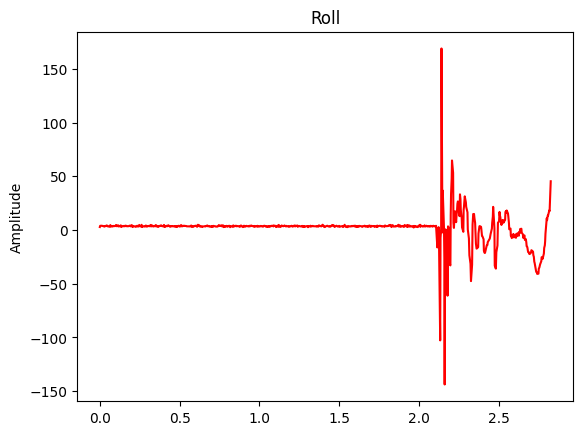

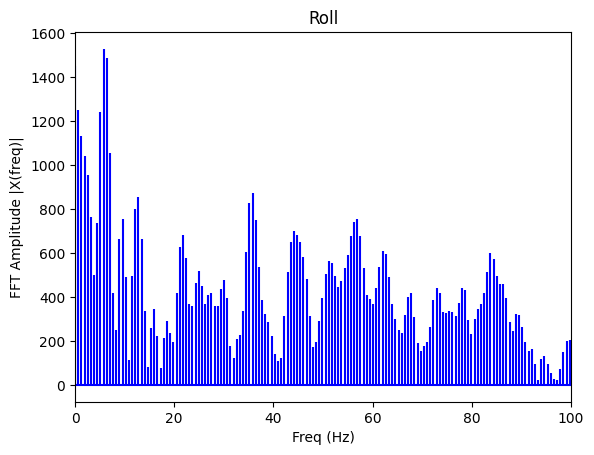

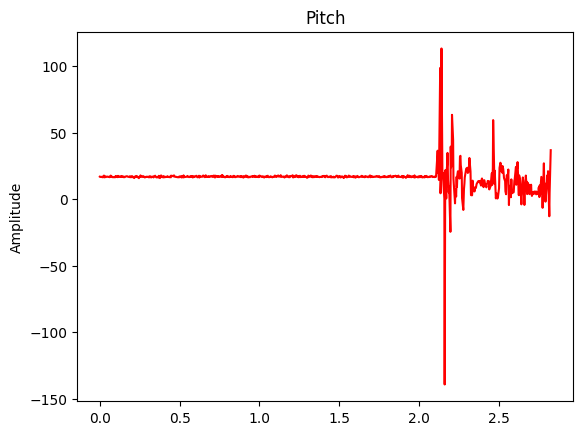

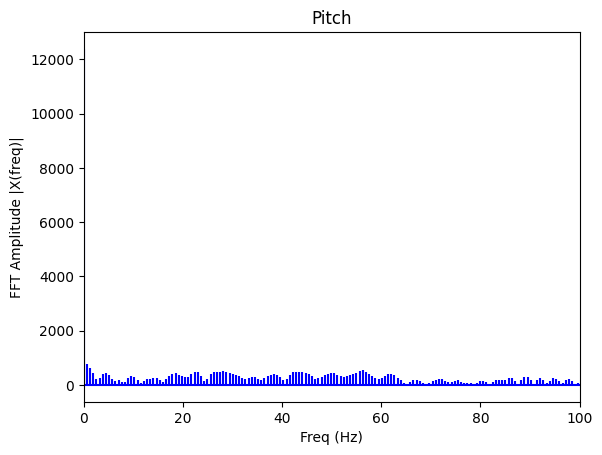

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

sample_rate = 500
sample_interval = 1.0 / sample_rate
# time = np.arange(0, 1, sample_interval)
time = np.array(time_data)

x = np.array(roll_data)
y = np.array(pitch_data)

# roll

# Plot the data
plt.plot(time, x, 'r')
plt.ylabel('Amplitude')
plt.title("Roll")
plt.show()

# Compute the Fourier transform
X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sample_rate
freq = n/T

# Plot the Fourier transform
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 100)
plt.title("Roll")
plt.show()

# pitch

# Plot the data
plt.plot(time, y, 'r')
plt.ylabel('Amplitude')
plt.title("Pitch")
plt.show()

# Compute the Fourier transform
X = fft(y)
N = len(X)
n = np.arange(N)
T = N/sample_rate
freq = n/T

# Plot the Fourier transform
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 100)
plt.title("Pitch")
plt.show()

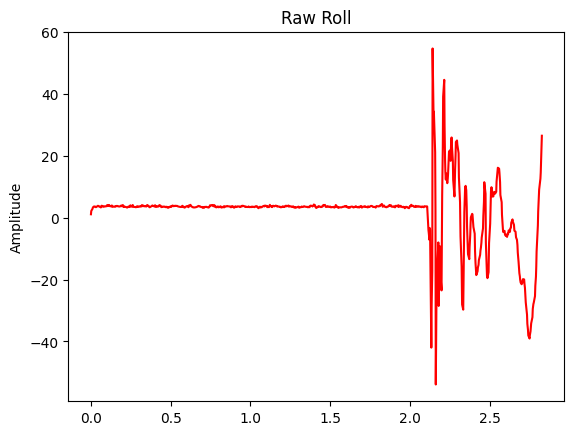

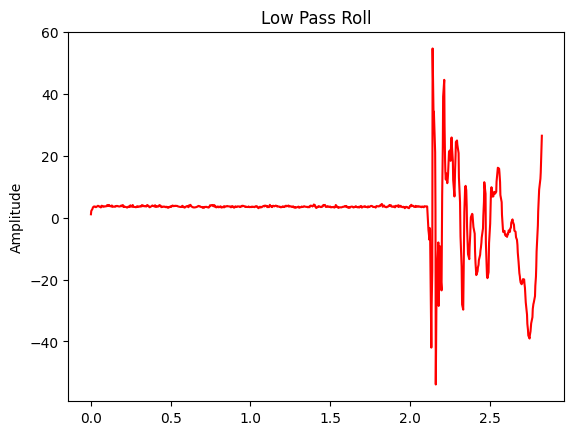

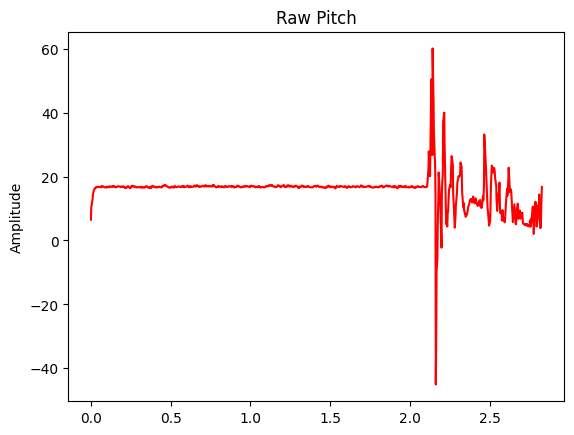

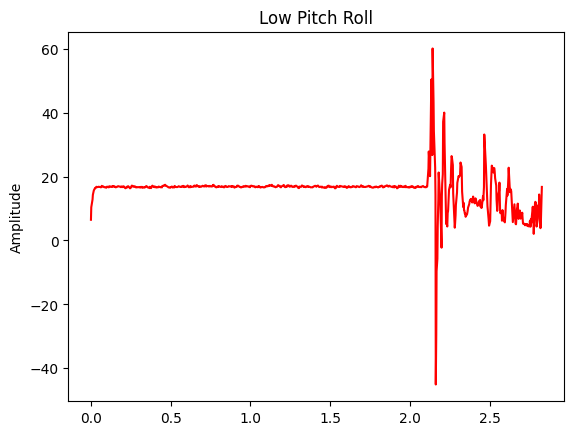

In [10]:
# Plot the data low pass
plt.plot(time, raw_roll, 'r')
plt.ylabel('Amplitude')
plt.title("Raw Roll")
plt.show()

plt.plot(time, lp_roll, 'r')
plt.ylabel('Amplitude')
plt.title("Low Pass Roll")
plt.show()

plt.plot(time, raw_pitch, 'r')
plt.ylabel('Amplitude')
plt.title("Raw Pitch")
plt.show()

plt.plot(time, lp_pitch, 'r')
plt.ylabel('Amplitude')
plt.title("Low Pitch Roll")
plt.show()

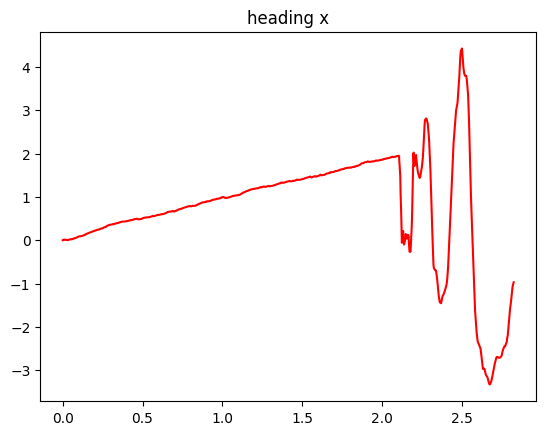

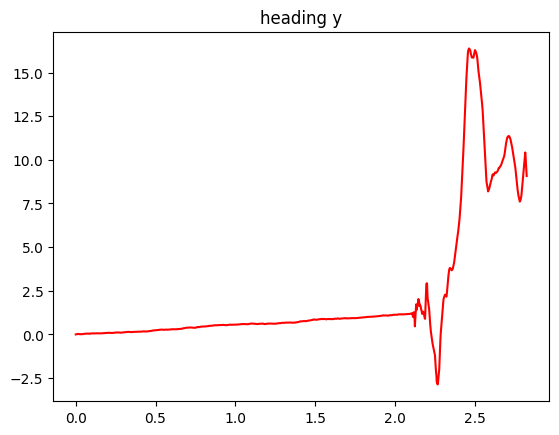

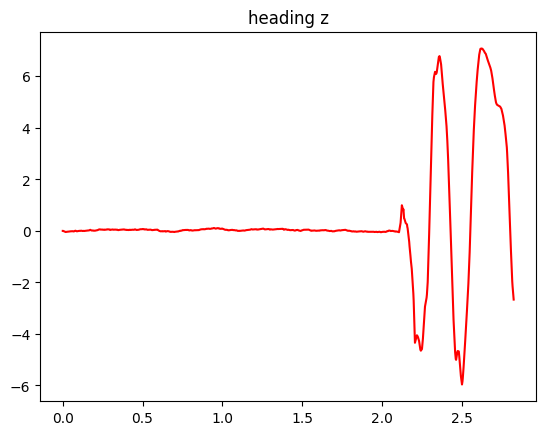

In [11]:
plt.plot(np.array(time_data), heading_x, 'r')
plt.title('heading x')
plt.show()

plt.plot(np.array(time_data), heading_y, 'r')
plt.title('heading y')
plt.show()

plt.plot(np.array(time_data), heading_z, 'r')
plt.title('heading z')
plt.show()

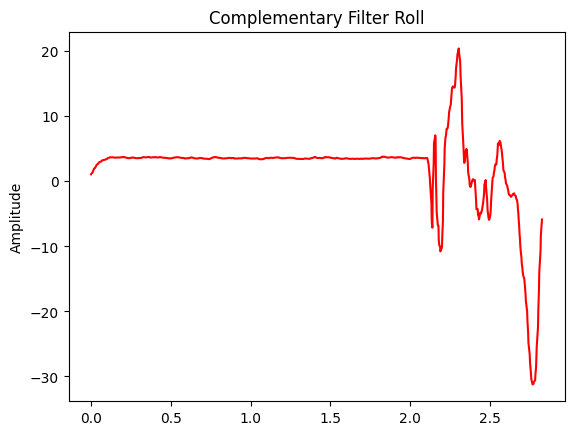

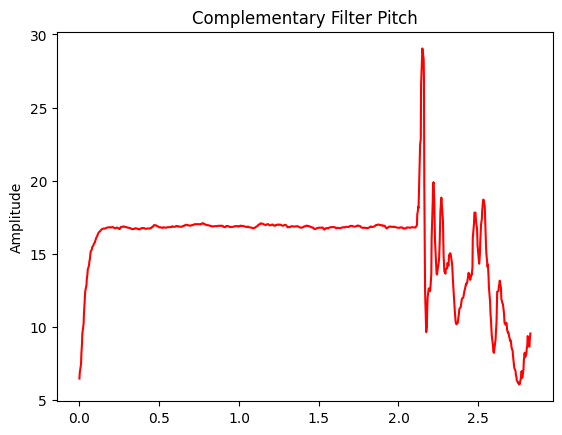

2024-02-13 14:51:00,388 | INFO     |: Disconnected from 324EB812-59E0-5CAF-B992-D25DCF474FBC


In [12]:
# plot compl data
plt.plot(time, compl_roll, 'r')
plt.ylabel('Amplitude')
plt.title("Complementary Filter Roll")
plt.show()

plt.plot(time, compl_pitch, 'r')
plt.ylabel('Amplitude')
plt.title("Complementary Filter Pitch")
plt.show()